In [3]:
# Step 1: Load and summarize the absenteeism dataset
import pandas as pd
from tabulate import tabulate

# Load the dataset
file_path = "Absenteeism_at_work.csv"
df = pd.read_csv(file_path)

# Clean column names and convert workload
df.rename(columns=lambda x: x.strip(), inplace=True)
df['Work load Average/day'] = df['Work load Average/day'].str.replace(',', '.').astype(float)

# Display descriptive statistics
summary = df.describe().transpose().round(2).drop("count", axis=1)
markdown_table = tabulate(summary, headers="keys", tablefmt="pipe")
print("### Step 1: Dataset Summary\n")
print(markdown_table)


### Step 1: Dataset Summary

|                                 |   mean |   std |    min |    25% |    50% |    75% |    max |
|:--------------------------------|-------:|------:|-------:|-------:|-------:|-------:|-------:|
| ID                              |  18.02 | 11.02 |   1    |   9    |  18    |  28    |  36    |
| Reason for absence              |  19.22 |  8.43 |   0    |  13    |  23    |  26    |  28    |
| Month of absence                |   6.32 |  3.44 |   0    |   3    |   6    |   9    |  12    |
| Day of the week                 |   3.91 |  1.42 |   2    |   3    |   4    |   5    |   6    |
| Seasons                         |   2.54 |  1.11 |   1    |   2    |   3    |   4    |   4    |
| Transportation expense          | 221.33 | 66.95 | 118    | 179    | 225    | 260    | 388    |
| Distance from Residence to Work |  29.63 | 14.84 |   5    |  16    |  26    |  50    |  52    |
| Service time                    |  12.55 |  4.38 |   1    |   9    |  13    |  16    | 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Step 2: Prepare binary target and features
df['High_Absenteeism'] = (df['Absenteeism time in hours'] > df['Absenteeism time in hours'].median()).astype(int)
X = df.drop(columns=['ID', 'Absenteeism time in hours', 'High_Absenteeism', 'Weight', 'Height'])  # remove multicollinear vars
y = df['High_Absenteeism']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8803, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit logistic regression model
model = LogisticRegression(max_iter=1000, random_state=8803)
model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

# Format outputs
conf_df = pd.DataFrame(conf_matrix, columns=["Pred 0", "Pred 1"], index=["Actual 0", "Actual 1"])
report_df = pd.DataFrame(report).transpose().round(2)

# Print markdown-style results
print("### Step 2: Confusion Matrix\n")
print(tabulate(conf_df, headers='keys', tablefmt='pipe'))
print("\n### Classification Report\n")
print(tabulate(report_df, headers='keys', tablefmt='pipe'))
print(f"\n### Overall Accuracy: {accuracy:.2%}")


### Step 2: Confusion Matrix

|          |   Pred 0 |   Pred 1 |
|:---------|---------:|---------:|
| Actual 0 |       95 |       25 |
| Actual 1 |       23 |       79 |

### Classification Report

|              |   precision |   recall |   f1-score |   support |
|:-------------|------------:|---------:|-----------:|----------:|
| 0            |        0.81 |     0.79 |       0.8  |    120    |
| 1            |        0.76 |     0.77 |       0.77 |    102    |
| accuracy     |        0.78 |     0.78 |       0.78 |      0.78 |
| macro avg    |        0.78 |     0.78 |       0.78 |    222    |
| weighted avg |        0.78 |     0.78 |       0.78 |    222    |

### Overall Accuracy: 78.38%


C:\Users\25413\AppData\Local\Temp\ipykernel_11732\3223766535.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label="Chance", color='gray')


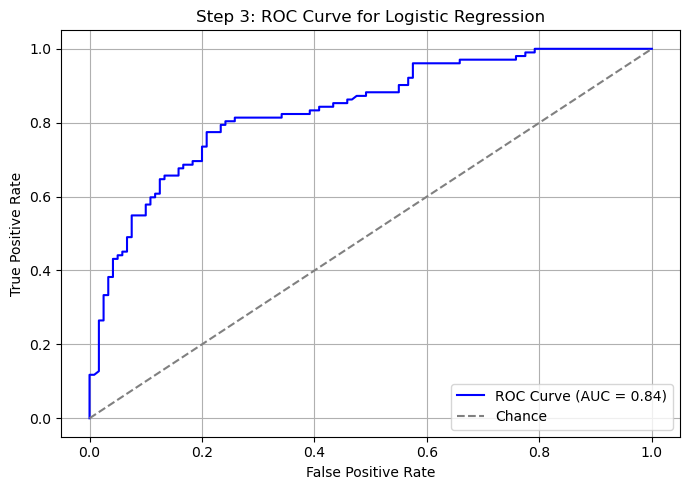

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

# Step 3: ROC Curve
y_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Chance", color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Step 3: ROC Curve for Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
# Step 4a: Extract and interpret model coefficients
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

# Print coefficients in markdown format
print("### Step 4a: Model Coefficients\n")
print(tabulate(coef_df, headers='keys', tablefmt='pipe'))


### Step 4a: Model Coefficients

|    | Feature                         |   Coefficient |
|---:|:--------------------------------|--------------:|
|  4 | Transportation expense          |     0.554226  |
| 12 | Son                             |     0.505279  |
| 13 | Social drinker                  |     0.393113  |
| 16 | Body mass index                 |     0.185613  |
|  1 | Month of absence                |     0.165836  |
|  8 | Work load Average/day           |     0.101653  |
| 11 | Education                       |     0.0973307 |
| 14 | Social smoker                   |     0.0781708 |
|  9 | Hit target                      |    -0.0065511 |
|  6 | Service time                    |    -0.0671714 |
|  7 | Age                             |    -0.14806   |
|  5 | Distance from Residence to Work |    -0.179945  |
|  2 | Day of the week                 |    -0.205037  |
|  3 | Seasons                         |    -0.212305  |
| 15 | Pet                             |    -0.276078  

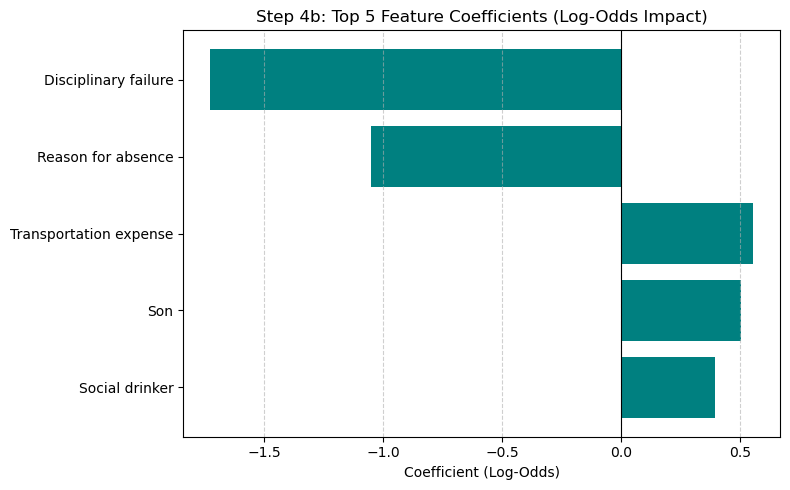

In [27]:
# Step 4b: Visualize top 5 most impactful features (by absolute value of coefficients)
top5_coef = coef_df.reindex(coef_df["Coefficient"].abs().sort_values(ascending=False).index).head(5)

# Plot
plt.figure(figsize=(8, 5))
bars = plt.barh(top5_coef["Feature"], top5_coef["Coefficient"], color="teal")
plt.axvline(0, color="black", linewidth=0.8)
plt.title("Step 4b: Top 5 Feature Coefficients (Log-Odds Impact)")
plt.xlabel("Coefficient (Log-Odds)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


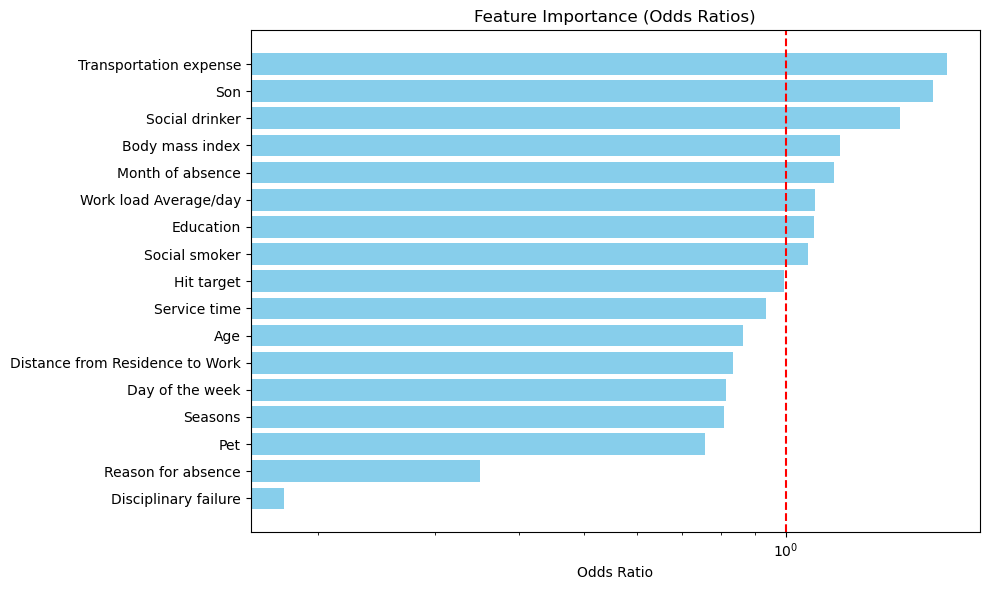

### Step 5: Odds Ratios

|    | Feature                         |   Coefficient |   Odds Ratio |
|---:|:--------------------------------|--------------:|-------------:|
|  4 | Transportation expense          |        0.5542 |       1.7406 |
| 12 | Son                             |        0.5053 |       1.6574 |
| 13 | Social drinker                  |        0.3931 |       1.4816 |
| 16 | Body mass index                 |        0.1856 |       1.2040 |
|  1 | Month of absence                |        0.1658 |       1.1804 |
|  8 | Work load Average/day           |        0.1017 |       1.1070 |
| 11 | Education                       |        0.0973 |       1.1022 |
| 14 | Social smoker                   |        0.0782 |       1.0813 |
|  9 | Hit target                      |       -0.0066 |       0.9935 |
|  6 | Service time                    |       -0.0672 |       0.9350 |
|  7 | Age                             |       -0.1481 |       0.8624 |
|  5 | Distance from Residence to Work 

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Step 5: Calculate and plot odds ratios
coef_df["Odds Ratio"] = np.exp(coef_df["Coefficient"])
coef_df = coef_df.sort_values("Odds Ratio", ascending=False)

# Plot odds ratios (log scale for better visibility)
plt.figure(figsize=(10, 6))
plt.barh(coef_df["Feature"], coef_df["Odds Ratio"], color="skyblue")
plt.axvline(1, color="red", linestyle="--")
plt.xlabel("Odds Ratio")
plt.title("Feature Importance (Odds Ratios)")
plt.gca().invert_yaxis()
plt.xscale("log")
plt.tight_layout()
plt.show()

# Print odds ratios in markdown format
print("### Step 5: Odds Ratios\n")
print(tabulate(coef_df[["Feature", "Coefficient", "Odds Ratio"]], headers="keys", tablefmt="pipe", floatfmt=".4f"))
